In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, itertools, psi
from sklearn.metrics import r2_score
from scipy.stats import linregress as regress

In [2]:
class psi_curve:
    def __init__(self, size=60, n=2, gamma=10, limit=15):
        """size is a linear size of required lattice, mean, that if size==10, that lattice is done as
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ^ 2
        
        so, if your date is in limits of [5, 10], you need to shift it to [0, 5] and use size = 6"""
        self.n = n
        self.gamma = gamma
        self.limit = limit
        self.a = (1 / gamma) / (gamma - 1)

        x = np.arange(size)
        #endpoint=True breaks the plot of curve, 
        #but allows work with [0, 1], not [0, 1)  
        self.coord = []
        for i in x:
            for j in x:
                result = psi.inner_function((i / size, j / size), gamma, n)[0]        
                self.coord.append((i, j, result))
        self.coord.sort(key=lambda x: x[2])
        self.x = np.array([i[0] for i in self.coord])
        self.y = np.array([i[1] for i in self.coord])
        
    def distance_from_coordinates(self, x):
        return np.where(np.logical_and((self.x == x[0]), (self.y == x[1])))[0][0]

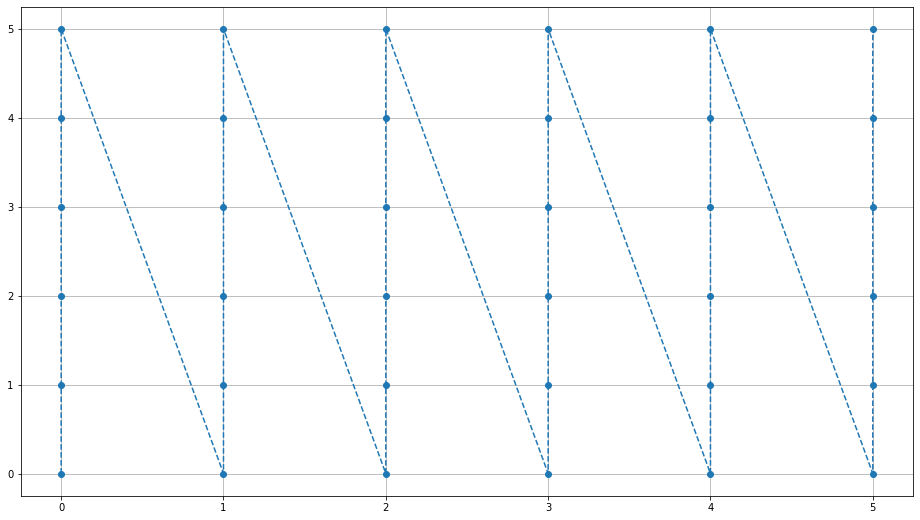

In [3]:
#checking that lattice is nice
lin_size = 60
_to = 36
plt.figure(figsize=(16, 9))
curve = psi_curve(size=lin_size)
plt.plot(curve.x[:_to], curve.y[:_to], 'o--')
plt.grid()
plt.savefig("psi_curve_num=60_zoom.png")
plt.show()

In [142]:
def toLatticeFunction(x, y):
    return (np.int(np.round((lin_size - 1) * x)), np.int(np.round((lin_size - 1) * y)))

def sub_archiver(full_size, regress_size, arrays):
    result = []
    for array in arrays:
        sqs = []
        slopes = []
        ints = []
        x = np.fromiter(range(regress_size), np.int32, count=-1)
        for y in np.split(np.array(array), full_size // regress_size):
            sq, slope, intercept = np.polyfit(x, y, 2)
            #slope, intercept = np.polyfit(x, y, 1)

            sqs.append(sq)
            slopes.append(slope)
            ints.append(intercept)

        result.append(sqs)
        result.append(slopes)
        result.append(ints)
    return result
    
def sub_dearchiver(full_size, regress_size, arrays):
    result = []
    for sqs, slopes, ints in zip(arrays[::3], arrays[1::3], arrays[2::3]):
#    for slopes, ints in zip(arrays[::2], arrays[1::2]):
        archx = list(range(full_size))
        archy = [ints[i // regress_size] + slopes[i // regress_size] * (i % regress_size)
                 + sqs[i // regress_size] * (i % regress_size) * (i % regress_size) for i in range(full_size)]
        #archy = [ints[i // regress_size] + slopes[i // regress_size] * (i % regress_size) for i in range(full_size)]

        result.append(archy)
    return result

class Approximator():
    def __init__(self, lin_size):
        self.array = np.zeros((lin_size, lin_size)) #powerfull machine learning technic
        self.curve = psi_curve(size=lin_size)
        self.lin_size = lin_size
        
    def predict(self, X):
        y = []
        for x in X:
            y.append(self.array[toLatticeFunction(x[0], x[1])])
        return y

    def fit(self, X, Y):
        subarray = np.zeros_like(self.array)
        for x, y in zip(X, Y):
            self.array[toLatticeFunction(x[0], x[1])] += y
            subarray[toLatticeFunction(x[0], x[1])] += 1
        for i in range(lin_size):
            for j in range(lin_size):
                self.array[i, j] /= max(1, subarray[i, j])
    
    def archiver(self):
        h = []
        for i in range(app.lin_size):
            for j in range(app.lin_size):
                h.append((app.curve.distance_from_coordinates((i, j)), app.array[i, j]))
        self.h = np.array(sorted(h, key=lambda x: x[0]))[:, 1]
        #level 1
        self.level1 = sub_archiver(lin_size * lin_size, lin_size // 10, [self.h])
        #level 2
        self.level2 = sub_archiver(lin_size * 10, lin_size // 10, self.level1)
        #level 3
        self.level3 = sub_archiver(10 * 10, 10, self.level2)
        #level 4
        self.level4 = sub_archiver(10, 10, self.level3)

    def dearchiver(self):
        #level 4
        self.level3 = sub_dearchiver(10, 10, self.level4)
        #level 3
        self.level2 = sub_dearchiver(10 * 10, 10, self.level3)
        #level 2
        self.level1 = sub_dearchiver(lin_size * 10, lin_size // 10, self.level2)
        #level 1
        self.h = sub_dearchiver(lin_size * lin_size, lin_size // 10, self.level1)[0]
        #from h to array
        self.array = np.zeros((lin_size, lin_size))
        for x, y in zip(range(lin_size * lin_size), self.h):
            self.array[curve.coord[x][0], curve.coord[x][1]] = y

In [143]:
N = 10 ** 6
x = np.random.sample(size=(N, 2))

In [175]:
def targetFunction(x, y):
#    return x*x + y*y
    return x*x + 2 * y * x + y*y

z = targetFunction(x[:, 0], x[:, 1])

In [176]:
#l1 = np.sqrt(x[:, 0]*x[:, 0] + x[:, 1]*x[:, 1]) / np.sqrt(2)
#l2 = np.sqrt(x[:, 0]*x[:, 0] + (0.5 - x[:, 1])*(0.5 - x[:, 1])) / np.sqrt(2)
#l = np.array(list(zip(l1, l2)))

In [177]:
app = Approximator(lin_size)
#z = x[:, 0]
#x = l
app.fit(x, z)
z_new = app.predict(x)
print("r2score: ", r2_score(z_new, z))
print("max rel error: ", np.max(np.abs(z_new - z)) / (np.max(z_new) - np.min(z_new)))
#app.array

r2score:  0.9996888924207923
max rel error:  0.016831553578721434


In [178]:
#plt.figure(figsize=(12, 9))
#plt.imshow(app.array, aspect='auto', origin='lower')
#plt.colorbar()
#plt.savefig("heatmap_xor_before.png")
#plt.show()

In [179]:
app.archiver()
print(np.array(app.h).shape)
#plt.figure(figsize=(16, 9))
#plt.plot(app.h[:], 'o')
#plt.title("g(\u03B7) for lattice 60x60")
#plt.grid()
#plt.show()

(3600,)


In [180]:
app.dearchiver()
z_new = app.predict(x)
print("r2score: ", r2_score(z_new, z))
print("max rel error: ", np.max(np.abs(z_new - z)) / (np.max(z_new) - np.min(z_new)))

r2score:  0.9996840652043881
max rel error:  0.018032669314276648


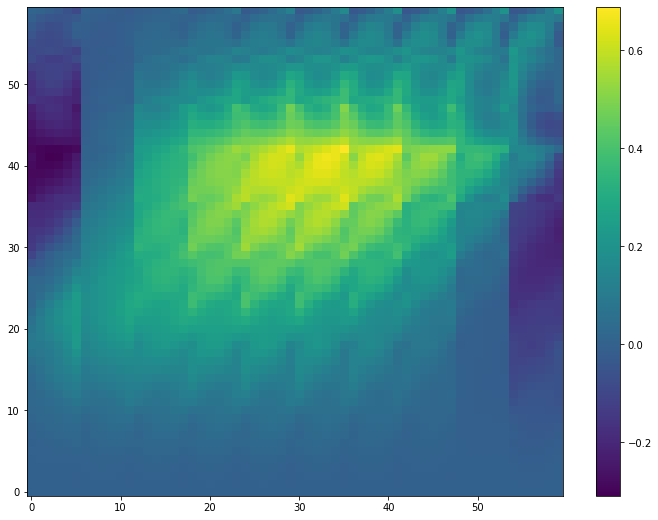

In [134]:
plt.figure(figsize=(12, 9))
plt.imshow(app.array, aspect='auto', origin='lower')
plt.colorbar()
plt.savefig("heatmap_xor_after.png")
plt.show()

In [ ]:
app.level2

In [ ]:
len(app.level4)

In [ ]:
len(app.h)

Plot approximations after archivation and after dearchivation

In [ ]:
app = Approximator(lin_size)
app.fit(x, y)
app.archiver()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(app.h, 'o--')
plt.grid()
plt.show()

In [ ]:
for i in app.level1:
    plt.figure(figsize=(16, 9))
    plt.plot(i[:], 'o')
    plt.grid()
    plt.show()

In [ ]:
for i in app.level2:
    plt.plot(i[:], 'o')
    plt.grid()
    plt.show()

In [ ]:
for i in app.level3:
    plt.plot(i, 'o')
    plt.grid()
    plt.show()

In [ ]:
app.level4

In [ ]:
print(r2_score(y, app.predict(x)))

In [ ]:
app.dearchiver()
print(r2_score(y, app.predict(x)))

In [ ]:
for i in app.level3:
    plt.plot(i, 'o')
    plt.grid()
    plt.show()

In [ ]:
for i in app.level2:
    plt.plot(i, 'o')
    plt.grid()
    plt.show()

In [ ]:
for i in app.level1:
    plt.plot(i[:200], 'o')
    plt.grid()
    plt.show()

In [ ]:
plt.plot(app.h[:500], 'o')
plt.grid()
plt.show()